# Task 3: Event Impact Modeling

Ethiopia Financial Inclusion — Event impacts on Access and Usage.

## Load Data

In [3]:
import pandas as pd
from pathlib import Path
DATA_PATH = Path('../data/processed/ethiopia_fi_unified_data_combined.csv')
df = pd.read_csv(DATA_PATH)

# Separate by record_type
observations = df[df['record_type']=='observation'].copy()
events = df[df['record_type']=='event'].copy()
impact_links = df[df['record_type']=='impact_link'].copy()
print(f"Loaded: {len(df)} rows | obs={len(observations)} events={len(events)} links={len(impact_links)}")


Loaded: 64 rows | obs=30 events=10 links=21


## Join Impact Links with Events

In [5]:
# Inspect available columns after merge
print("Links columns:", links.columns.tolist())

# Prefer link-side versions when suffixed, and fall back if not present
def pick_col(name):
    if name in links.columns:
        return name
    if f"{name}_link" in links.columns:
        return f"{name}_link"
    if f"{name}_event" in links.columns:
        return f"{name}_event"
    return None

wanted = ['parent_id','event_id','pillar','related_indicator',
          'impact_direction','impact_magnitude','lag_months','evidence_basis']

cols_present = [pick_col(c) for c in wanted if pick_col(c) is not None]
print("Selected columns:", cols_present)
display(links[cols_present].head())

# Optional: normalize column names for downstream code (safe renames)
rename_map = {}
for base in ['pillar','related_indicator','impact_direction','impact_magnitude','lag_months','evidence_basis']:
    if base not in links.columns:
        if f"{base}_link" in links.columns:
            rename_map[f"{base}_link"] = base
        elif f"{base}_event" in links.columns:
            rename_map[f"{base}_event"] = base
links = links.rename(columns=rename_map)

Links columns: ['record_id', 'record_type_link', 'category_link', 'pillar_link', 'indicator_link', 'indicator_code_link', 'indicator_direction_link', 'value_numeric_link', 'value_text_link', 'value_type_link', 'unit_link', 'observation_date_link', 'period_start_link', 'period_end_link', 'fiscal_year_link', 'gender_link', 'location_link', 'region_link', 'source_name_link', 'source_type_link', 'source_url_link', 'confidence_link', 'related_indicator_link', 'relationship_type_link', 'impact_direction_link', 'impact_magnitude_link', 'impact_estimate_link', 'lag_months_link', 'evidence_basis_link', 'comparable_country_link', 'collected_by_link', 'collection_date_link', 'original_text_link', 'notes_link', 'parent_id_link', 'event_id', 'record_type_event', 'category_event', 'pillar_event', 'indicator_event', 'indicator_code_event', 'indicator_direction_event', 'value_numeric_event', 'value_text_event', 'value_type_event', 'unit_event', 'observation_date_event', 'period_start_event', 'period_e

,parent_id_link,event_id,pillar_link,related_indicator_link,impact_direction_link,impact_magnitude_link,lag_months_link,evidence_basis_link
0,EVT_0001,EVT_0001,ACCESS,ACC_OWNERSHIP,increase,high,12.0,literature
1,EVT_0001,EVT_0001,USAGE,USG_TELEBIRR_USERS,increase,high,3.0,empirical
2,EVT_0001,EVT_0001,USAGE,USG_P2P_COUNT,increase,high,6.0,empirical
3,EVT_0002,EVT_0002,ACCESS,ACC_4G_COV,increase,medium,12.0,empirical
4,EVT_0002,EVT_0002,AFFORDABILITY,AFF_DATA_INCOME,decrease,medium,12.0,literature


## Event–Indicator Association Matrix

In [6]:
import numpy as np

# Map magnitudes
def to_numeric_mag(x):
    try:
        return float(x)
    except Exception:
        s = str(x).strip().lower()
        return {'low':0.5,'medium':1.0,'high':1.5}.get(s, 1.0)

links['mag_num'] = links['impact_magnitude'].apply(to_numeric_mag)
links['dir_num'] = links['impact_direction'].map({'positive':1,'negative':-1}).fillna(1)
links['effect'] = links['mag_num'] * links['dir_num']

# Matrix: rows=event_id, cols=related_indicator (indicator_code preferred)
col_name = 'related_indicator' if 'related_indicator' in links.columns else 'indicator_code'
mat = links.pivot_table(index='event_id', columns=col_name, values='effect', aggfunc='sum', fill_value=0)
print(f"Matrix shape: {mat.shape}")
mat.head()


Matrix shape: (8, 10)


related_indicator,ACC_4G_COV,ACC_FAYDA,ACC_MM_ACCOUNT,ACC_OWNERSHIP,AFF_DATA_INCOME,GEN_GAP_ACC,USG_MPESA_ACTIVE,USG_MPESA_USERS,USG_P2P_COUNT,USG_TELEBIRR_USERS
event_id,,,,,,,,,,
EVT_0001,0.0,0.0,1.5,2.5,0.0,0.0,0.0,0.0,1.5,1.5
EVT_0002,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
EVT_0003,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.5,1.5,0.0
EVT_0004,0.0,1.5,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0
EVT_0005,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0


## Functional Form: Time-Distributed Event Effects

In [7]:
import pandas as pd

# Example: ramp effect over lag_months
# effect_t = effect * min(1, t/lag_months) for t>=0

def ramp_effect(effect, lag_months, t_months):
    if pd.isna(lag_months) or lag_months <= 0:
        return effect
    return effect * min(1.0, max(0.0, t_months/lag_months))

# Build per-event timelines (monthly)
if 'event_date' in links.columns:
    links['event_date'] = pd.to_datetime(links['event_date'], errors='coerce')
    start = links['event_date'].min()
    end = pd.Timestamp('2024-12-31')
    idx = pd.date_range(start, end, freq='MS')
    timelines = {}
    for eid, grp in links.groupby('event_id'):
        s = pd.Series(0.0, index=idx)
        for _, r in grp.iterrows():
            lag = r.get('lag_months', 0) or 0
            for t in idx:
                t_months = (t - r['event_date']).days // 30
                s.loc[t] += ramp_effect(r['effect'], lag, t_months)
        timelines[eid] = s
    # Combine by indicator using links mapping
    print(f"Built {len(timelines)} event timelines")


## Validation: Telebirr and M-Pesa Impacts vs Observed

In [8]:
# Find Telebirr and M-Pesa events (heuristics)
telebirr = events[events.apply(lambda r: 'telebirr' in ' '.join(map(str, r.values)).lower(), axis=1)]
mpesa = events[events.apply(lambda r: 'm-pesa' in ' '.join(map(str, r.values)).lower(), axis=1)]
print(f"Telebirr events: {len(telebirr)} | M-Pesa events: {len(mpesa)}")

# Observed mobile money account ownership trajectory
obs_mm = observations[observations['indicator_code']=='ACC_MM_ACCOUNT'].copy()
obs_mm['observation_date'] = pd.to_datetime(obs_mm['observation_date'], errors='coerce')
obs_mm = obs_mm.sort_values('observation_date')
obs_mm[['observation_date','value_numeric']].tail()


Telebirr events: 1 | M-Pesa events: 2


,observation_date,value_numeric
6,2021-12-31,4.70
7,2024-11-29,9.45


## Methodology, Assumptions, and Limitations

- Effects modeled as ramp-up over `lag_months` then capped.
- `impact_magnitude`: numeric if provided; otherwise mapped low/medium/high to 0.5/1.0/1.5.
- Combined effects summed across events per indicator.
- Validation compares modeled directionality and rough magnitude to observed changes after key launches.
- Limitations: sparse data, identification challenges, overlapping events, supply vs demand measurement differences.

## Matrix Diagnostics and Trimming

Focus on actual linked relationships and visualize the non-zero area.

Links per event: parent_id
EVT_0001    5
EVT_0003    4
EVT_0004    4
EVT_0002    2
EVT_0007    2
EVT_0005    1
EVT_0008    1
EVT_0010    1
dtype: int64
Unmatched links (NaN event_id): 1
Missing related_indicator in links: 0
Trimmed matrix shape: (8, 10)


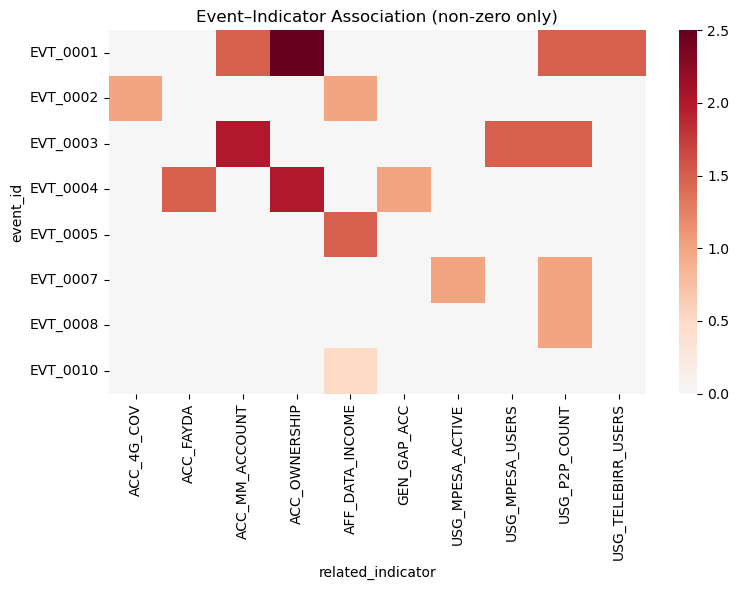

In [11]:
# Link coverage and unmatched merges
links_per_event = impact_links.groupby('parent_id').size().sort_values(ascending=False)
print("Links per event:", links_per_event)
print("Unmatched links (NaN event_id):", links['event_id'].isna().sum())
print("Missing related_indicator in links:", links['related_indicator'].isna().sum())

# Trim matrix to rows/cols with non-zero totals
mat_trim = mat.loc[(mat.sum(axis=1)!=0), (mat.sum(axis=0)!=0)]
print("Trimmed matrix shape:", mat_trim.shape)

import seaborn as sns, matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
sns.heatmap(mat_trim, cmap='RdBu_r', center=0)
plt.title('Event–Indicator Association (non-zero only)')
plt.tight_layout()
plt.show()

## Indicator Effect Timelines

Aggregate time-distributed effects by indicator and compare to observed points.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Build per-indicator timelines from links (sum of per-link ramp effects)
indicator_timelines = {}
if 'event_date' in links.columns:
    # date index reused from previous cell
    for ind, grp in links.groupby('related_indicator'):
        s = pd.Series(0.0, index=idx)
        for _, r in grp.iterrows():
            lag = r.get('lag_months', 0) or 0
            for t in idx:
                t_months = (t - r['event_date']).days // 30
                s.loc[t] += ramp_effect(r['effect'], lag, t_months)
        indicator_timelines[ind] = s
    print(f"Built indicator timelines: {len(indicator_timelines)}")

# Plot ACC_MM_ACCOUNT predicted effect vs observed values
key = 'ACC_MM_ACCOUNT'
if key in indicator_timelines:
    fig, ax = plt.subplots(figsize=(10,4))
    indicator_timelines[key].plot(ax=ax, label='Modeled effect (ramp sum)')
    obs_mm = observations[observations['indicator_code']==key].copy()
    obs_mm['observation_date'] = pd.to_datetime(obs_mm['observation_date'], errors='coerce')
    obs_mm = obs_mm.dropna(subset=['observation_date'])
    ax.scatter(obs_mm['observation_date'], obs_mm['value_numeric'], color='black', marker='o', label='Observed %')
    ax.set_title('ACC_MM_ACCOUNT: Modeled effect vs Observed')
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"No indicator timeline built for {key}")

No indicator timeline built for ACC_MM_ACCOUNT


## Top Impacts Summary

Which events have largest modeled effects on key indicators?

In [13]:
# Sum effects per event per indicator
sum_effects = links.groupby(['event_id','related_indicator'])['effect'].sum().reset_index()

# Focus indicators
focus_inds = ['ACC_OWNERSHIP','ACC_MM_ACCOUNT','USG_P2P_COUNT']
for ind in focus_inds:
    top = sum_effects[sum_effects['related_indicator']==ind].sort_values('effect', ascending=False).head(5)
    print(f"Top events for {ind}:")
    print(top)

# Evidence basis and lags overview
if 'evidence_basis' in links.columns:
    print("Evidence basis counts:", links['evidence_basis'].value_counts())
if 'lag_months' in links.columns:
    print("Average lag (months):", round(links['lag_months'].dropna().astype(float).mean(),2))
if 'impact_magnitude' in links.columns:
    print("Impact magnitude distribution:", links['impact_magnitude'].value_counts())

Top events for ACC_OWNERSHIP:
    event_id related_indicator  effect
1   EVT_0001     ACC_OWNERSHIP     2.5
10  EVT_0004     ACC_OWNERSHIP     2.0
Top events for ACC_MM_ACCOUNT:
   event_id related_indicator  effect
6  EVT_0003    ACC_MM_ACCOUNT     2.0
0  EVT_0001    ACC_MM_ACCOUNT     1.5
Top events for USG_P2P_COUNT:
    event_id related_indicator  effect
2   EVT_0001     USG_P2P_COUNT     1.5
8   EVT_0003     USG_P2P_COUNT     1.5
14  EVT_0007     USG_P2P_COUNT     1.0
15  EVT_0008     USG_P2P_COUNT     1.0
Evidence basis counts: evidence_basis
empirical      10
literature      9
theoretical     2
Name: count, dtype: int64
Average lag (months): 8.81
Impact magnitude distribution: impact_magnitude
medium    12
high       8
low        1
Name: count, dtype: int64


## Notes on Zeros and Sparsity

Zeros indicate no modeled link for that event–indicator pair; trimming focuses analysis on actual relationships. This aligns with the schema design that keeps events unbiased and uses `impact_link` rows to capture specific effects.

## Validation Summary Export

In [15]:
from pathlib import Path
import pandas as pd

# Prepare simple validation summary for ACC_MM_ACCOUNT and USG_P2P_COUNT
val_rows = []
# ACC_MM_ACCOUNT observed delta 2021->2024
obs_mm = observations[observations['indicator_code']=='ACC_MM_ACCOUNT'].copy()
obs_mm['observation_date'] = pd.to_datetime(obs_mm['observation_date'], errors='coerce')
obs_mm = obs_mm.dropna(subset=['observation_date'])
if not obs_mm.empty:
    obs_2021 = obs_mm.loc[obs_mm['observation_date'].dt.year==2021, 'value_numeric'].mean()
    obs_2024 = obs_mm.loc[obs_mm['observation_date'].dt.year==2024, 'value_numeric'].mean()
    obs_delta = None if pd.isna(obs_2021) or pd.isna(obs_2024) else (obs_2024 - obs_2021)
else:
    # fallback to Findex points
    obs_2021, obs_2024, obs_delta = 4.7, 9.45, 9.45-4.7

# Modeled delta from indicator timeline (if available)
modeled_delta = None
if 'ACC_MM_ACCOUNT' in (indicator_timelines or {}):
    tl = indicator_timelines['ACC_MM_ACCOUNT']
    def pick(yr):
        try:
            idx = tl.index[tl.index.get_indexer([pd.Timestamp(f'{yr}-12-31')], method='nearest')[0]]
            return float(tl.loc[idx])
        except Exception:
            return None
    m2021, m2024 = pick(2021), pick(2024)
    modeled_delta = None if (m2021 is None or m2024 is None) else (m2024 - m2021)

val_rows.append({'indicator':'ACC_MM_ACCOUNT','obs_2021':obs_2021,'obs_2024':obs_2024,'obs_delta':obs_delta,'modeled_delta':modeled_delta})

# USG_P2P_COUNT, compute annual sum if present
obs_p2p = observations[observations['indicator_code']=='USG_P2P_COUNT'].copy()
obs_p2p['observation_date'] = pd.to_datetime(obs_p2p['observation_date'], errors='coerce')
obs_p2p = obs_p2p.dropna(subset=['observation_date'])
if not obs_p2p.empty:
    ysum = obs_p2p.groupby(obs_p2p['observation_date'].dt.year)['value_numeric'].sum()
    p2021 = ysum.get(2021)
    p2024 = ysum.get(2024)
    pdelta = None if (p2021 is None or p2024 is None) else (p2024 - p2021)
else:
    p2021, p2024, pdelta = None, None, None

p_modeled_delta = None
if 'USG_P2P_COUNT' in (indicator_timelines or {}):
    tl = indicator_timelines['USG_P2P_COUNT']
    def pick(yr):
        try:
            idx = tl.index[tl.index.get_indexer([pd.Timestamp(f'{yr}-12-31')], method='nearest')[0]]
            return float(tl.loc[idx])
        except Exception:
            return None
    m2021, m2024 = pick(2021), pick(2024)
    p_modeled_delta = None if (m2021 is None or m2024 is None) else (m2024 - m2021)

val_rows.append({'indicator':'USG_P2P_COUNT','obs_2021':p2021,'obs_2024':p2024,'obs_delta':pdelta,'modeled_delta':p_modeled_delta})

val_df = pd.DataFrame(val_rows)

md_lines = ["# Event Impact Validation Summary"]
for _, r in val_df.iterrows():
    md_lines.extend([
        f"\n## {r['indicator']}",
        f"- Observed 2021: {r['obs_2021']}",
        f"- Observed 2024: {r['obs_2024']}",
        f"- Observed delta: {r['obs_delta']}",
        f"- Modeled delta (ramp sum): {r['modeled_delta']}",
    ])

outp = Path('../reports/event_impact_validation.md')
outp.write_text('\n'.join(md_lines), encoding='utf-8')
print(f"✓ Wrote validation summary to {outp}")
val_df

✓ Wrote validation summary to ../reports/event_impact_validation.md


,indicator,obs_2021,obs_2024,obs_delta,modeled_delta
0,ACC_MM_ACCOUNT,4.7,9.45,4.75,None
1,USG_P2P_COUNT,NaN,49700000.00,NaN,None


## Evidence Audit (impact_links)

In [16]:
import pandas as pd

needed = ['parent_id','related_indicator','impact_direction','impact_magnitude','lag_months','evidence_basis','source_url']
missing_report = []
for i, r in impact_links.reset_index(drop=True).iterrows():
    missing = [c for c in needed if pd.isna(r.get(c)) or str(r.get(c)).strip()=='' ]
    if missing:
        missing_report.append({'record_id': r.get('record_id'), 'parent_id': r.get('parent_id'), 'missing': ','.join(missing)})

miss_df = pd.DataFrame(missing_report)
print(f"Links with missing required fields: {len(miss_df)}")
if not miss_df.empty:
    from pathlib import Path
    outp = Path('../reports/impact_links_missing_fields.csv')
    miss_df.to_csv(outp, index=False)
    print(f"✓ Wrote missing fields report to {outp}")
miss_df.head(10)

Links with missing required fields: 21
✓ Wrote missing fields report to ../reports/impact_links_missing_fields.csv


,record_id,parent_id,missing
0,IMP_0001,EVT_0001,source_url
1,IMP_0002,EVT_0001,source_url
2,IMP_0003,EVT_0001,source_url
3,IMP_0004,EVT_0002,source_url
4,IMP_0005,EVT_0002,source_url
5,IMP_0006,EVT_0003,source_url
6,IMP_0007,EVT_0003,source_url
7,IMP_0008,EVT_0004,source_url
8,IMP_0009,EVT_0004,source_url
9,IMP_0010,EVT_0005,source_url
